In [10]:
import numpy as np
import pandas as pd
from itertools import product
from collections import Counter
import re
from sklearn.svm import SVC, LinearSVC
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.cross_validation import cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from collections import defaultdict
import scipy.stats as stats
import matplotlib.pylab as plt
from scipy.sparse import csr_matrix, vstack, hstack
from keras.layers import GRU, LSTM, Dense, Flatten, Dropout, Merge, InputLayer, Input
from keras.models import Sequential
from keras import regularizers
%matplotlib inline

In [11]:
alphabet = u'абвгдеёжзийклмнопрстуфхцчшщъыьэюя'
vowel = u'аеёиоуыэюя'

In [12]:
data = pd.read_csv("linear_train.txt", sep=',', encoding='utf-8', header=None)
data['word_len'] = data[0].apply(len)
data = data[data.word_len < 20]
train, test = train_test_split(data, train_size=0.75)

In [ ]:
features = np.vstack([(data[0].apply(lambda s: s[0].upper() == s[0] and s.upper() != s)).values,
                      (data[0].apply(lambda s: s.upper() == s)).values,
                      (data[0].apply(len) <= 3).values,
                      (data[0].apply(len) > 3).values,
                      (data[0].apply(lambda s: len(re.findall(u'[^а-яА-ЯёЁ]', s)) > 0)).values,
                      (data[0].apply(lambda s: sum([1 for ch in s if ch in vowel]))).values]).T

In [ ]:
vectorizer = TfidfVectorizer(analyzer='char_wb', ngram_range=(2, 6), lowercase=True, binary=True)
vectorizer.fit(data[0].apply(lambda w: '$' + w + '$'))

voc = np.array(vectorizer.get_feature_names())[vectorizer.idf_ < 7]
word_index = {word: index for index, word in enumerate(voc)}
len(voc)

In [ ]:
sizes = (2, 3, 4, 5, 6)
X = []
for word, label in data[[0, 1]].values:
    x = np.zeros(len(voc))
    w = '$' + word.lower() + '$'
    for q in sizes:
        if q > len(w):
            continue
        for i in range(len(w) - q + 1):
            if w[i: i + q] in word_index:
                x[word_index[w[i: i + q]]] = 1
    X.append(x)
qgram_features = np.array(np.hstack([X, features]))    

In [13]:
vectorizer = CountVectorizer(analyzer='char_wb', ngram_range=(2, 6), lowercase=True, binary=True)
qgram_features = hstack([features, vectorizer.fit_transform(data[0].apply(lambda w: '$' + w + '$'))])
qgram_features.shape

NameError: name 'features' is not defined

In [41]:
np.mean(cross_val_score(LogisticRegression(C=0.0005), qgram_features, data[1].values, scoring='roc_auc', cv=5, n_jobs=8))

0.7854494423853231

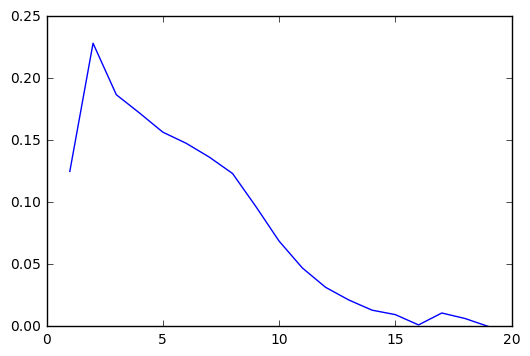

In [7]:
plt.plot(data.groupby('word_len')[1].mean())

In [14]:
letters = np.unique(list(''.join(data[0])))
letters = list(letters) + ['$']
letters = [letter for letter in letters if letter.lower() == letter]
letter_index = {letter: index for index, letter in enumerate(letters)}
n = len(letters) + 2

In [14]:
m1 = Sequential()
m1.add(LSTM(100, return_sequences=True, input_shape=(20, n)))
m1.add(LSTM(100))

m2 = Sequential()
m2.add(InputLayer(input_shape=(qgram_features.shape[1],)))
#m2.add(InputLayer(input_shape=(qgram_features.shape[1])))

model = Sequential()
model.add(Merge([m1, m2], mode='concat'))
model.add(Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l2(0.001)))
model.compile(loss="binary_crossentropy", optimizer="rmsprop")

NameError: name 'qgram_features' is not defined

In [15]:
q = 1
model = Sequential()
model.add(LSTM(100, input_shape=(20 - q + 1, n * q)))
#model.add(Dropout(0.5))
#model.add(LSTM(100))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss="binary_crossentropy", optimizer="rmsprop")

In [16]:
X = []
y = []
for word, label in data[[0, 1]].values:
    word_features = []
    w = word + '$' * (20 - len(word))
    for i in range(len(w) - q + 1):
        letter_features = np.zeros(n * q)
        
        for j in range(q):
            letter = w[i + j]
            if letter.lower() in letter_index:
                letter_features[n * j + letter_index[letter.lower()]] = 1
            else:
                letter_features[n * j + n - 2] = 1
            if letter.lower() != letter:
                letter_features[n * j + n - 1] = 1
            #if letter.lower() in vowel:
            #    letter_features[n * j + n - 2] = 1

        word_features.append(letter_features)
    X.append(np.array(word_features))
    y.append(np.array([label]))
X = np.array(X)
y = np.array(y)

In [17]:
X.shape

(101303, 20, 52)

In [18]:
y.shape

(101303, 1)

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75)

In [21]:
res = []
for i in range(100):
    model.fit(X_train, y_train, batch_size=1024, nb_epoch=2)
    
    y_pred = model.predict(X_train)
    r1 = roc_auc_score(y_train, y_pred)
    
    y_pred = model.predict(X_test)
    r2 = roc_auc_score(y_test, y_pred)
    
    print(r1, r2)
    
    res.append((r1, r2))

Epoch 1/2
75977/75977 [==============================] - 65s - loss: 0.3143    
Epoch 2/2
75977/75977 [==============================] - 74s - loss: 0.2560    
(0.85194327137101211, 0.85658828629039596)
Epoch 1/2
75977/75977 [==============================] - 79s - loss: 0.2482    
Epoch 2/2
75977/75977 [==============================] - 86s - loss: 0.2411    
(0.86999397174204685, 0.87057568036111632)
Epoch 1/2
38912/75977 [==============>...............] - ETA: 34s - loss: 0.2386

KeyboardInterrupt: 

In [1]:
res = []
for i in range(10):
    model.fit([X_train, qgram_train], y_train, batch_size=1024, epochs=2)
    
    y_pred = model.predict([X_train, qgram_train])
    r1 = roc_auc_score(y_train, y_pred)
    
    y_pred = model.predict([X_test, qgram_test])
    r2 = roc_auc_score(y_test, y_pred)
    
    print(r1, r2)
    
    res.append((r1, r2))

NameError: name 'model' is not defined

In [17]:
y_pred = model.predict([X_train, qgram_train.todense()])
r1 = roc_auc_score(y_train, y_pred)

y_pred = model.predict([X_test, qgram_test.todense()])
r2 = roc_auc_score(y_test, y_pred)

print(r1, r2)

res.append((r1, r2))

0.88067938092 0.881339935469


In [22]:
res1 = res

In [23]:
print(res1)

[(0.87559820858063431, 0.87477819610799257), (0.89946018755182156, 0.89800593420314989), (0.91696830855642375, 0.91625424440592551), (0.92353264610811636, 0.9225078668525879), (0.93005952300873063, 0.92884919911305552), (0.937011126926244, 0.9353119151125594), (0.94230501741180805, 0.94098947956753665), (0.94987696703881852, 0.94832552297114181), (0.94932676166692165, 0.94757079150501944), (0.96013868421375825, 0.95815824135002103)]


In [14]:
y_pred = model.predict(X_train)

In [15]:
roc_auc_score(y_train, y_pred)

0.93341952705900544

In [17]:
y_pred = model.predict(X_test)

In [18]:
roc_auc_score(y_test, y_pred)

0.93100723675870756

In [309]:
test_data = pd.read_csv("linear_test.txt", sep=',', encoding='utf-8', header=None)

In [310]:
y_pred = []
for word in test_data[0].values:
    success = True
    if len(word) <= 20:
        word_features = []
        for letter in word + '$' * (20 - len(word)):
            if letter.lower() not in letter_index:
                success = False
            else:
                letter_features = np.zeros(n)
                letter_features[letter_index[letter.lower()]] = 1
                if letter.lower() != letter:
                    letter_features[-1] = 1
                word_features.append(letter_features)
    else:
        success = False
        
    if success:
        y_pred.append(model.predict(np.array([word_features]))[0, 0])
    else:
        y_pred.append(0)

In [284]:
model.predict(X).flatten()

array([ 0.76186055,  0.19935369,  0.27581999, ...,  0.00213335,
        0.0089693 ,  0.00888431], dtype=float32)

In [314]:
ans = pd.DataFrame({'Id': np.arange(len(y_pred)), 'Answer': y_pred})

In [315]:
ans[['Id', 'Answer']].to_csv('ans.csv', sep=',', header=True, index=False)

In [316]:
ans

,Answer,Id
0,0.000000,0
1,0.187119,1
2,0.305428,2
3,0.297203,3
4,0.477572,4
5,0.506581,5
6,0.760643,6
7,0.541946,7
8,0.541946,8
9,0.574611,9


In [287]:
list(zip(test_data[0].values, y_pred))

[('\ufeffАалто', 0),
 ('ААР', 0.18700713),
 ('Аара', 0.20067768),
 ('Ааре', 0.21470776),
 ('Аарон', 0.27582005),
 ('Аароне', 0.10360982),
 ('Ааронов', 0.58525681),
 ('Аароном', 0.15514761),
 ('Аароном', 0.15514761),
 ('Аарону', 0.15541333),
 ('Аарону', 0.15541333),
 ('Аахен', 0.6571992),
 ('Аахене', 0.010947071),
 ('Аахеном', 0.42917034),
 ('АБ', 0.053766981),
 ('Абадан', 0.0065700915),
 ('Абадане', 0.012151382),
 ('Абаданом', 0.023970373),
 ('Абаев', 0.99697238),
 ('Абаева', 0.99953592),
 ('Абаевым', 0.99967253),
 ('Абажур', 0.00082075369),
 ('абажура', 0.00051940884),
 ('абажурами', 0.00016527569),
 ('абажурах', 0.00022788702),
 ('абажуре', 0.00023753765),
 ('абажуров', 0.0001540925),
 ('абажуру', 0.00030739355),
 ('Абак', 0.048942804),
 ('АБАК', 0.010833487),
 ('абака', 0.086430594),
 ('Абака', 0.037977934),
 ('Абакан', 0.0034134844),
 ('Абакане', 0.0067527601),
 ('абаках', 0.00083182496),
 ('абаке', 0.0010626049),
 ('Абаке', 0.008780499),
 ('абаки', 0.049785912),
 ('Абаки', 0.00681

In [22]:
data = pd.read_csv('task2_lemmas_train', sep=',', )

CParserError: Error tokenizing data. C error: Expected 3 fields in line 102, saw 4
